In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
from scipy.stats import median_abs_deviation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from pyod.models.pca import PCA

In [23]:
# Inlezen van data en invullen van NaN
freezer = pd.read_csv('freezerdata_clean_outliers.csv', index_col=0)
freezer = freezer.interpolate(method='linear', limit_direction='forward', axis=0)
freezer = freezer.copy()[1:]

# Het maken van opdracht 1
fig = go.Figure()

outliers = freezer[freezer['Outlier'] == 1]

fig.add_trace(go.Scatter(x=freezer.Date, y=freezer.Refrigerated, name='Refrigerated'))
fig.add_trace(go.Scatter(x=outliers.Date, y=outliers.Refrigerated, mode='markers', marker={'color': 'red'}, name='Anomalies'))
fig.add_vrect('2023-03-16 10:40:00', '2023-03-16 14:10:00', annotation_text='First and second anomaly', annotation_position='top left',
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect('2023-03-17 09:40:00', '2023-03-17 13:00:00', annotation_text='Third and fourth anomaly', annotation_position='top left',
              fillcolor="red", opacity=0.25, line_width=0)

fig.show()

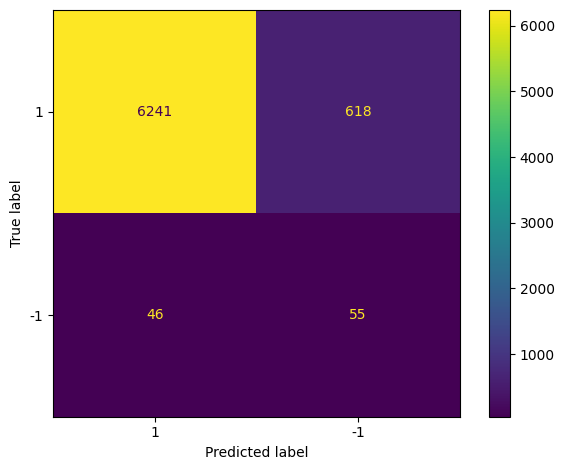

In [24]:
# Opdracht 2
freezer['Anomaly'] = np.where(freezer['Outlier'] == 0, 1, -1)

mad = median_abs_deviation(freezer['Refrigerated'])
median = np.median(freezer['Refrigerated'])

def compute_robust_z_score(x):
    return .6745*(x-median)/mad

freezer['z-score'] = freezer['Refrigerated'].apply(compute_robust_z_score)

freezer['baseline'] = 1

freezer.loc[freezer['z-score'] >= 3.5, 'baseline'] = -1 # Right-end tail
freezer.loc[freezer['z-score'] <= -3.5, 'baseline'] = -1 # Left-hand tail

cm = confusion_matrix(freezer['Anomaly'], freezer['baseline'], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot()

plt.grid(False)
plt.tight_layout()

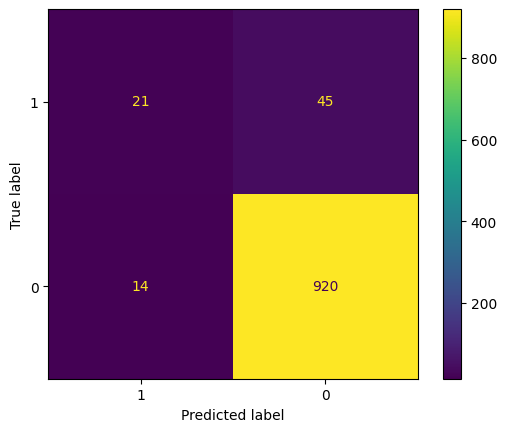

In [28]:
# Opdracht 3
for column in freezer.columns[3:8]:
    freezer[column] = freezer[column].diff().fillna(0)

freezer

test_start = 2000
test_end = test_start + 1000

# Opdracht 4
X_train_pd = freezer.loc[:, ['Door', 'Environment', 'HotGasPipe', 'LiquidPipe', 'Refrigerated', 'SuctionPipe']]

X_train = X_train_pd.to_numpy()

y_train = freezer.loc[:, 'Outlier']

X_test_pd = X_train_pd.copy()[test_start:test_end]
X_test = X_test_pd.to_numpy()

pca = PCA(contamination=0.027)
pca.fit(X_train)

preds = pca.predict(X_test)

cm = confusion_matrix(freezer.loc[(test_start + 1):test_end, ['Outlier']], preds, labels=[1, 0])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, 0])

disp_cm.plot()

In [27]:
# Opdracht 5
preds_check = freezer.loc[(test_start + 1):test_end, ['Date', 'Door', 'Environment', 'HotGasPipe', 'LiquidPipe', 'SuctionPipe', 'Refrigerated', 'Outlier']]
preds_check['preds'] = preds
preds_check['correct'] = np.where((preds_check['Outlier'] == 0) & (preds_check['preds'] == 0), 'Correct Inlier', np.where(
                                    (preds_check['Outlier'] == 1) & (preds_check['preds'] == 1), 'Correct Outlier', np.where(
                                        (preds_check['Outlier'] == 0) & (preds_check['preds'] == 1), 'False Positive', 'False Negative')))

fig = px.scatter(preds_check, 'LiquidPipe', 'HotGasPipe', 'correct')
fig.show()

# Opdracht 6 Kan je zelf wel invullen ;)